<a href="https://colab.research.google.com/github/Debangan-MishraIIIT/CNN-LSTM-model-for-stocks/blob/main/A_CNN_LSTM_Based_Model_to_Forecast_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following notebook is the implementation of the paper ["A CNN-LSTM-Based Model to Forecast Stock Prices"](https://www.hindawi.com/journals/complexity/2020/6622927/) which utilises a combination of convolutional neural networks and LSTM networks to make predictions regarding stock prices of the Shanghai Composite Index.

In [41]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch

The paper takes the daily trading
data of 7127 trading days from July 1, 1991, to August 31, 2020, from the wind database however dure to cost and convenience, I have used the historical prices information from the Yahoo Finance API. This API records the daily trading data of Shanghai Composite Index starting from 1997-07-02 which is why the ending date is taken to be 2024-01-01. Still due to lack of data, information about only 6421 days is available compelling 80-20 train test split. Note that the split should not include shuffling because of the linear nature of the time series data.

In [42]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [43]:
ticker = yf.Ticker("000001.SS")
df= ticker.history(start="1997-07-01", end="2024-01-01")

In [44]:
df2= df[['Close']]
df3= df2.reset_index()

In [45]:
df3

,Date,Close
0,1997-07-02 00:00:00+08:00,1199.061035
1,1997-07-03 00:00:00+08:00,1150.623047
2,1997-07-04 00:00:00+08:00,1159.342041
3,1997-07-07 00:00:00+08:00,1096.818970
4,1997-07-08 00:00:00+08:00,1109.666016
...,...,...
6416,2023-12-25 00:00:00+08:00,2918.812988
6417,2023-12-26 00:00:00+08:00,2898.879883
6418,2023-12-27 00:00:00+08:00,2914.614014
6419,2023-12-28 00:00:00+08:00,2954.704102


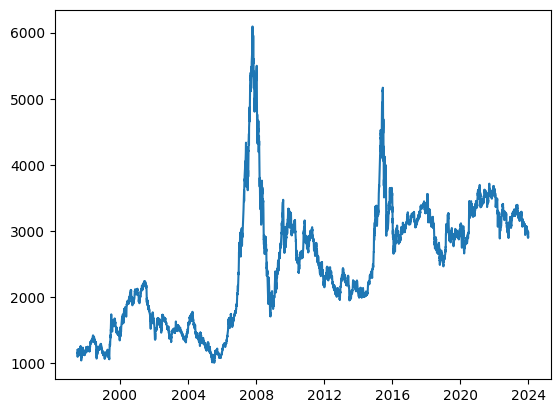

In [46]:
plt.plot(df3['Date'], df3['Close'])
plt.show()

In [47]:
np_arr= np.array(df3['Close'])

In [48]:
#Additionally, I have normalized the stock price data as in observation, it gives better results
mean= np_arr.mean()
std= np_arr.std()
np_arr= (np_arr-mean)/std

In [49]:
print(mean, std)

2471.538428441588 911.6204426444947


The model design is as per the paper, with a slight modification- time step is taken to be 1 instead of 10 and the dimensions are following the convention (Batch Size, Size of Window, Time Step) rather than (Batch Size, Time Step, Size of Window) as followed in the paper to account for differences in PyTorch implementation. For further reference- look at figure 4

In [50]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.CNNModel= nn.Sequential(
        nn.Conv1d(in_channels=8, out_channels=32, kernel_size=1, padding="same"),
        nn.Tanh(),
        nn.MaxPool1d(kernel_size=1, padding=0),
        nn.ReLU()
    )
    self.LSTMModel= nn.Sequential(
        nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
    )
    self.LinearModel= nn.Sequential(
        nn.Tanh(),
        nn.Linear(in_features=64, out_features=1)
    )

  def forward(self, data):
    out1= self.CNNModel(data)
    out2, _= self.LSTMModel(data)
    out3= self.LinearModel(out2[:, -1, :])
    out4= torch.reshape(out3, (len(out2), ))
    return out4

In [51]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        self.length = len(X_data)

    def __getitem__(self, index):
        x = self.X_data[index]
        y = self.y_data[index]
        return x, y

    def __len__(self):
        return self.length

In [52]:
def create_windows(arr, window):
  X,y=[],[]
  for i in range(window, len(arr)):
    X.append(arr[i-window:i])
    y.append(arr[i])
  return torch.reshape((torch.tensor(X)).to(torch.float32), (len(X), window, 1)), (torch.tensor(y)).to(torch.float32)

In [53]:
device= "cuda:0" if torch.cuda.is_available() else "cpu" #training on GPU for convenience
print(device)
train_size= int(len(np_arr)*0.8)

cuda:0


In [54]:
#this value determines how many past days will be considered for the price prediction, and the value is same as the
#number of features parameter mentioned in paper
lookback= 8
X_train, y_train = create_windows(np_arr[:train_size], lookback)
X_test, y_test = create_windows(np_arr[train_size:], lookback)

train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

num_epoch= 100
model = Model()
model = model.to(device)
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.L1Loss()

for epoch in range(num_epoch):
    model.train()
    train_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        lossv = loss(y_pred, y)
        train_loss += lossv

        optim.zero_grad()
        lossv.backward()
        optim.step()

    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            lossw = loss(y_pred, y)
            test_loss += lossw

        test_loss /= len(test_loader)

    print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
# Plotting for each combination of lookback and number of epochs

Epoch: 1/100, Train Loss: 0.6199, Test Loss: 0.5617
Epoch: 2/100, Train Loss: 0.2409, Test Loss: 0.0979
Epoch: 3/100, Train Loss: 0.1724, Test Loss: 0.1032
Epoch: 4/100, Train Loss: 0.1482, Test Loss: 0.0963
Epoch: 5/100, Train Loss: 0.1257, Test Loss: 0.1025
Epoch: 6/100, Train Loss: 0.1000, Test Loss: 0.0512
Epoch: 7/100, Train Loss: 0.0961, Test Loss: 0.0671
Epoch: 8/100, Train Loss: 0.1119, Test Loss: 0.0462
Epoch: 9/100, Train Loss: 0.0917, Test Loss: 0.0725
Epoch: 10/100, Train Loss: 0.0939, Test Loss: 0.0492
Epoch: 11/100, Train Loss: 0.0753, Test Loss: 0.0782
Epoch: 12/100, Train Loss: 0.0731, Test Loss: 0.0679
Epoch: 13/100, Train Loss: 0.1011, Test Loss: 0.0499
Epoch: 14/100, Train Loss: 0.1256, Test Loss: 0.0967
Epoch: 15/100, Train Loss: 0.0775, Test Loss: 0.0385
Epoch: 16/100, Train Loss: 0.0878, Test Loss: 0.0570
Epoch: 17/100, Train Loss: 0.0764, Test Loss: 0.0545
Epoch: 18/100, Train Loss: 0.0730, Test Loss: 0.0558
Epoch: 19/100, Train Loss: 0.1151, Test Loss: 0.0691
Ep

As we can see from the following graph, the model is accurately predicting the time series as we see a strong overlap between real and predicted data.

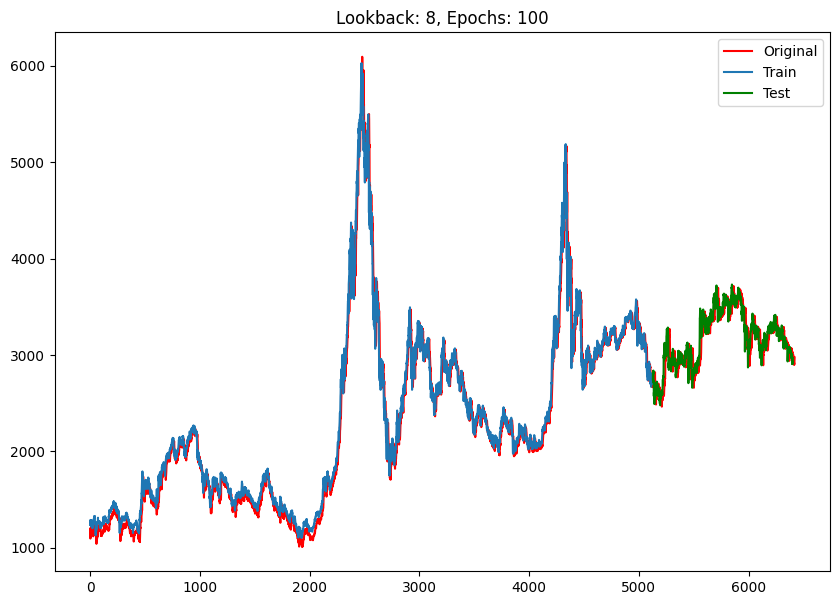

In [55]:
model.eval()
with torch.no_grad():
    train_outputs = []
    for X, _ in train_loader:
        X = X.to(device)
        y_pred = model(X)
        train_outputs.append(y_pred.cpu().numpy())

    train_outputs = np.concatenate(train_outputs)

test_outputs = []
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        y_pred = model(X)
        test_outputs.append(y_pred.cpu().numpy())

test_outputs = np.concatenate(test_outputs)

#multiplying back the mean and standard deviation, essentially undoing the normalization before plotting
plt.figure(figsize=(10, 7))
plt.plot(range(len(np_arr)), np_arr*std+mean, label="Original", c="r")
plt.plot(range(len(train_outputs)), train_outputs*std+mean, label="Train")
plt.plot(range(len(train_outputs), len(train_outputs) + len(test_outputs)), test_outputs*std+mean, label="Test", c="g")
plt.title(f"Lookback: {lookback}, Epochs: {num_epoch}")
plt.legend()
plt.show()

The metrics obtained in the paper for CNN-LSTM were MAE=27.564, RMSE=39.688, and R-square=0.9646. The values obtained from my implementation are fairly similar though we have to account differences in the training data and duration from which the data was taken.


In [56]:
y_test2= y_test*std+mean
test_outputs2= test_outputs*std+mean

from sklearn.metrics import mean_squared_error, r2_score
y_test_np = y_test2.detach().numpy()
l1_loss = torch.nn.L1Loss()(torch.from_numpy(test_outputs2), y_test2).item()
r_squared = r2_score(y_test_np, test_outputs2)
rmse = np.sqrt(mean_squared_error(y_test_np, test_outputs2))
print(f"MAE Loss: {l1_loss}")
print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

L1 Loss: 26.394086837768555
R-squared: 0.9837456349002749
RMSE: 35.630985260009766
